# Define the pdfs

We need to ensure that the pdfs are properly truncated

In [112]:
from scipy.stats import crystalball, truncexpon, uniform, truncnorm
import scipy
from numba import njit, float64
import numba_stats as nbs
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from scipy.optimize import brute, minimize

#help(nbs.truncexpon)

In [155]:
#define the parameters
mu = 3.0
sigma = 0.3
beta = 1.0
m = 1.4
f = 0.6
lmbda = 0.3
mu_b = 0.0
sigma_b = 2.5

#define upper and lower limits
X_ulim = 5.0
X_llim = 0.0
Y_ulim = 10.0
Y_llim = 0.0

#define the functions using scipy stats
def g_s(X):
    return crystalball.pdf(X, beta, m, mu, sigma) / (crystalball.cdf(X_ulim, beta, m, mu, sigma) - crystalball.cdf(X_llim, beta, m, mu, sigma))

def h_s(Y):
    trunc_b = (Y_ulim - Y_llim)*lmbda
    return truncexpon.pdf(Y, trunc_b, Y_llim, 1/lmbda)

def g_b(X):
    return uniform.pdf(X, X_llim, X_ulim)

def h_b(Y):
    a = (mu_b - Y_llim)/sigma_b
    b = (Y_ulim - mu_b)/sigma_b
    return truncnorm.pdf(Y, a, b, mu_b, sigma_b)

#define the functions using numba-stats for quicker sampling
@njit(float64(float64, float64, float64, float64, float64, float64, float64))
def g_s_nb(X, beta, m, mu, sigma, X_llim, X_ulim):
    return nbs.crystalball.pdf(np.array([X], dtype = np.float64), beta, m, mu, sigma)[0] / (nbs.crystalball.cdf(np.array([X_ulim], dtype=np.float64), beta, m, mu, sigma)[0]
        - nbs.crystalball.cdf(np.array([X_llim], dtype=np.float64), beta, m, mu, sigma)[0]) 

@njit(float64(float64, float64, float64, float64))
def h_s_nb(Y, lmbda, Y_llim, Y_ulim):
    y_arr = np.array([Y], dtype=np.float64)
    return nbs.truncexpon.pdf(y_arr, Y_llim, Y_ulim, Y_llim, 1/lmbda)[0]

@njit(float64(float64, float64, float64, float64))
def h_s_nb(Y, lmbda, Y_llim, Y_ulim):
    if Y <= Y_ulim and Y >= Y_llim:
        #the way numba stats and scipy stats treat edge values are different, so add small buffer
        return nbs.truncexpon.pdf(np.array([Y], dtype=np.float64), Y_llim - 1e-10, Y_ulim + 1e-10, 0.0, 1/lmbda)[0]
    return 0.0

@njit(float64(float64, float64, float64))
def g_b_nb(X, X_llim, X_ulim):
    return nbs.uniform.pdf(np.array([X], dtype=np.float64), X_llim, X_ulim-X_llim)[0]

@njit(float64(float64, float64, float64, float64, float64))
def h_b_nb(Y, mu_b, sigma_b, Y_llim, Y_ulim):
    if Y <= Y_ulim and Y >= Y_llim:
        #the way numba stats and scipy stats treat edge values are different, so add small buffer
        return nbs.truncnorm.pdf(np.array([Y], dtype=np.float64), Y_llim-1e-10, Y_ulim+1e-10, mu_b, sigma_b)[0]
    return 0.0



In [154]:
#test that they are the same
x_test = np.linspace(0, 5, 100)
y_test = np.linspace(0, 10, 100)

# Compare g_s and g_s_nb
g_s_results = [g_s(x) for x in x_test]  
g_s_nb_results = [g_s_nb(x, beta, m, mu, sigma, X_llim, X_ulim) for x in x_test]

# Check if values are close within tolerance
np.testing.assert_allclose(g_s_results, g_s_nb_results, rtol=1e-10)
print("g_s functions match!")

# Test g_b functions
g_b_results = [g_b(x) for x in x_test]
g_b_nb_results = [g_b_nb(x, X_llim, X_ulim) for x in x_test]
np.testing.assert_allclose(g_b_results, g_b_nb_results, rtol=1e-10)
print("g_b functions match!")



# Print parameters being used
print(f"\nParameters:")
print(f"mu_b={mu_b}, sigma_b={sigma_b}, Y_llim={Y_llim}, Y_ulim={Y_ulim}")

# Test h_b functions
h_b_results = [h_b(y) for y in y_test]
h_b_nb_results = [h_b_nb(y, mu_b, sigma_b, Y_llim, Y_ulim) for y in y_test]
np.testing.assert_allclose(h_b_results, h_b_nb_results, rtol=1e-10)
print("h_b functions match!")

# Print first few values to compare
for i in range(5):
    print(f"y={y_test[i]:.3f}, h_b={h_b_results[i]:.6f}, h_b_nb={h_b_nb_results[i]:.6f}")

max_diff_idx_b = np.argmax(np.abs(np.array(h_b_results) - np.array(h_b_nb_results)))
print(f"Largest difference at y={y_test[max_diff_idx_b]}")
print(f"h_b: {h_b_results[max_diff_idx_b]}")
print(f"h_b_nb: {h_b_nb_results[max_diff_idx_b]}")

# Test h_s functions
h_s_results = [h_s(y) for y in y_test]
h_s_nb_results = [h_s_nb(y, lmbda, Y_llim, Y_ulim) for y in y_test]
np.testing.assert_allclose(h_s_results, h_s_nb_results, rtol=1e-10)
print("h_s functions match!")

for i in range(5):
    print(f"y={y_test[i]:.3f}, h_s={h_s_results[i]:.6f}, h_s_nb={h_s_nb_results[i]:.6f}")

max_diff_idx_s = np.argmax(np.abs(np.array(h_s_results) - np.array(h_s_nb_results)))
print(f"Largest difference at y={y_test[max_diff_idx_s]}")
print(f"h_s: {h_b_results[max_diff_idx_s]}")
print(f"h_s_nb: {h_b_nb_results[max_diff_idx_s]}")



g_s functions match!
g_b functions match!

Parameters:
mu_b=0.0, sigma_b=2.5, Y_llim=0.0, Y_ulim=10.0
h_b functions match!
y=0.000, h_b=0.319174, h_b_nb=0.319174
y=0.101, h_b=0.318914, h_b_nb=0.318914
y=0.202, h_b=0.318134, h_b_nb=0.318134
y=0.303, h_b=0.316838, h_b_nb=0.316838
y=0.404, h_b=0.315033, h_b_nb=0.315033
Largest difference at y=0.0
h_b: 0.31917404159766277
h_b_nb: 0.3191740415874722
h_s functions match!
y=0.000, h_s=0.315719, h_s_nb=0.315719
y=0.101, h_s=0.306295, h_s_nb=0.306295
y=0.202, h_s=0.297153, h_s_nb=0.297153
y=0.303, h_s=0.288283, h_s_nb=0.288283
y=0.404, h_s=0.279678, h_s_nb=0.279678
Largest difference at y=0.0
h_s: 0.31917404159766277
h_s_nb: 0.3191740415874722


Plot these pdfs to visualise what they look like

[0.3157187  0.31099482 0.30634162 0.30175804 0.29724304 0.2927956
 0.2884147  0.28409935 0.27984857 0.27566139 0.27153685 0.26747403
 0.263472   0.25952985 0.25564669 0.25182162 0.24805379 0.24434233
 0.2406864  0.23708518 0.23353784 0.23004357 0.22660159 0.2232111
 0.21987135 0.21658156 0.213341   0.21014893 0.20700461 0.20390735
 0.20085642 0.19785115 0.19489083 0.19197482 0.18910243 0.18627302
 0.18348595 0.18074057 0.17803627 0.17537244 0.17274846 0.17016375
 0.1676177  0.16510975 0.16263933 0.16020587 0.15780882 0.15544764
 0.15312178 0.15083072 0.14857395 0.14635094 0.14416119 0.1420042
 0.13987949 0.13778657 0.13572497 0.13369421 0.13169383 0.12972339
 0.12778243 0.12587051 0.12398719 0.12213206 0.12030468 0.11850464
 0.11673154 0.11498497 0.11326452 0.11156983 0.10990048 0.10825612
 0.10663636 0.10504083 0.10346918 0.10192104 0.10039606 0.09889391
 0.09741422 0.09595668 0.09452095 0.0931067  0.09171361 0.09034136
 0.08898964 0.08765815 0.08634658 0.08505464 0.08378202 0.0825284

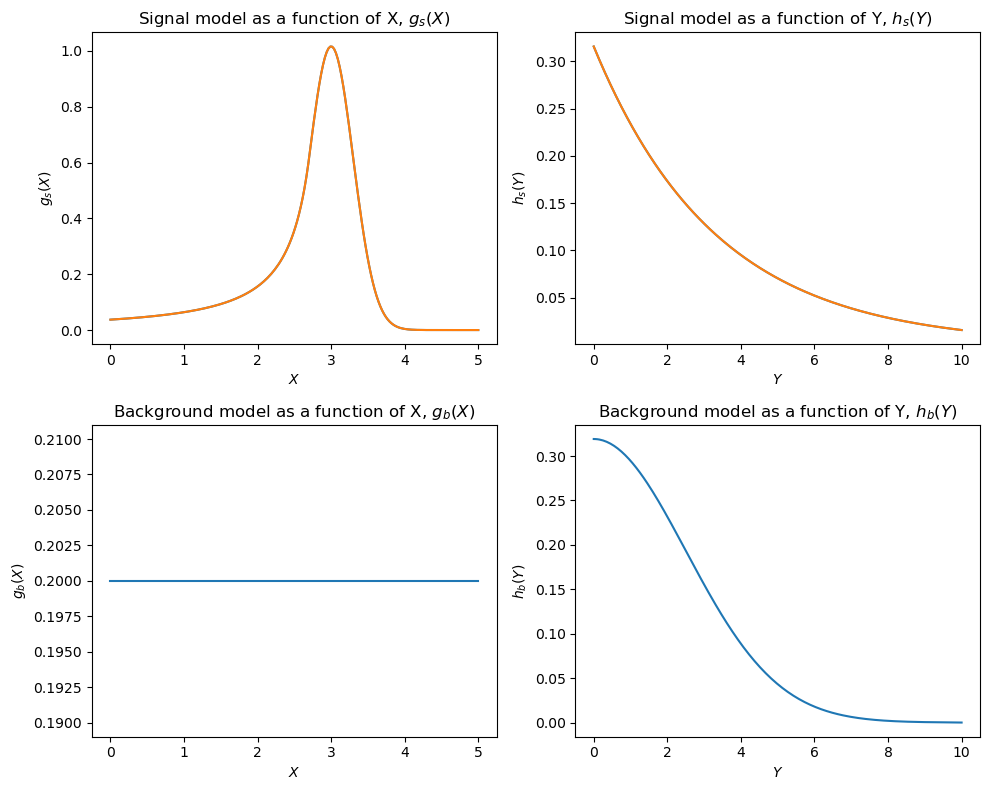

In [114]:
# Create a 2x2 grid of plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8)) 

x = np.linspace(0, 5, 200)
y = np.linspace(0, 10, 200)

#plot the signal for X
ax[0,0].plot(x, g_s(x))

ax[0,0].plot(x, np.array([g_s_nb(x_val, beta, m, mu, sigma, X_llim, X_ulim) for x_val in x]))
ax[0,0].set_title(r'Signal model as a function of X, $g_s(X)$')
ax[0,0].set_ylabel(r'$g_s(X)$')
ax[0,0].set_xlabel(r'$X$')

#plot the signal for Y
ax[0,1].plot(y, np.array([h_s_nb(y_val, lmbda, Y_llim, Y_ulim) for y_val in y]))
ax[0,1].plot(y, h_s(y))
ax[0,1].set_title(r'Signal model as a function of Y, $h_s(Y)$')
ax[0,1].set_ylabel(r'$h_s(Y)$')
ax[0,1].set_xlabel(r'$Y$')
print(np.array([h_s_nb(y_val, lmbda, Y_llim, Y_ulim) for y_val in y]))
print(y[-1])

#plot the background for X
ax[1,0].plot(x, np.array([g_b_nb(x_val, X_llim, X_ulim) for x_val in x]))
ax[1,0].set_title(r'Background model as a function of X, $g_b(X)$')
ax[1,0].set_ylabel(r'$g_b(X)$')
ax[1,0].set_xlabel(r'$X$')

#plot the background for Y
ax[1,1].plot(y, np.array([h_b_nb(y_val, mu_b, sigma_b, Y_llim, Y_ulim) for y_val in y]))
ax[1,1].set_title(r'Background model as a function of Y, $h_b(Y)$')
ax[1,1].set_ylabel(r'$h_b(Y)$')
ax[1,1].set_xlabel(r'$Y$')

plt.tight_layout()


Numeric integration to show that they are normalised

In [115]:
#can change the parameters to ensure correct normalisation always
mu = 4
sigma = 9
beta = 12
m = 12
f = 0.8
lmbda = 9
mu_b = 2
sigma_b = 3


integral_g_s = scipy.integrate.quad(g_s, X_llim, X_ulim)
integral_h_s = scipy.integrate.quad(h_s, Y_llim, Y_ulim)
integral_g_b = scipy.integrate.quad(g_b, X_llim, X_ulim)
integral_h_b = scipy.integrate.quad(h_b, Y_llim, Y_ulim)

print(f'Integral of g_s is {integral_g_s[0]: 0.1f}, with error {integral_g_s[1]}.')
print(f'Integral of h_s is {integral_h_s[0]: 0.1f}, with error {integral_h_s[1]}.')
print(f'Integral of g_b is {integral_g_b[0]: 0.1f}, with error {integral_g_b[1]}.')
print(f'Integral of h_b is {integral_h_b[0]: 0.1f}, with error {integral_h_b[1]}.')

Integral of g_s is  1.0, with error 1.110223024625157e-14.
Integral of h_s is  1.0, with error 4.98081735191946e-13.
Integral of g_b is  1.0, with error 1.1102230246251569e-14.
Integral of h_b is  1.0, with error 4.109627083082046e-10.


Plot the probability distribution $P_X = g_b(X)+g_s(X)$ and $P_Y = h_b(Y)+h_s(Y)$ and make sure they are normalised.

In [116]:
#define original parameters again
mu = 3
sigma = 0.3
beta = 1
m = 1.4
f = 0.6
lmbda = 0.3
mu_b = 0
sigma_b = 2.5

In [117]:
def P_X(x):
    return (1-f) * g_b(x) + f * g_s(x)

def P_Y(y):
    return (1-f) * h_b(y) + f * h_s(y)

In [118]:
#numba-stats functions
@njit(float64(float64))
def P_X_nb(x):
   return (1-f) * g_b_nb(x, X_llim, X_ulim) + f * g_s_nb(x, beta, m, mu, sigma, X_llim, X_ulim)

@njit(float64(float64))
def P_Y_nb(y):
   return (1-f) * h_b_nb(y, mu_b, sigma_b, Y_llim, Y_ulim) + f * h_s_nb(y, lmbda, Y_llim, Y_ulim)

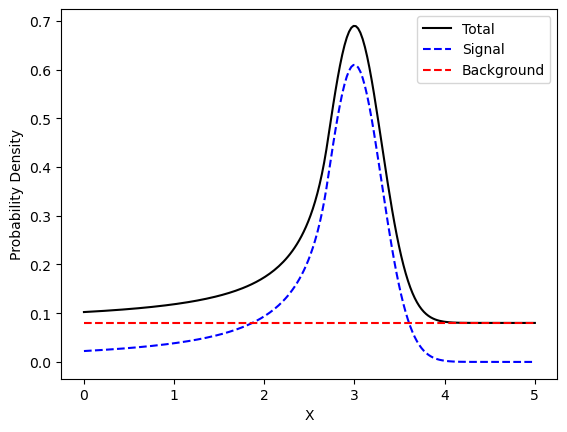

In [119]:
plt.plot(x, P_X(x), 'k-', label='Total')
plt.plot(x, f*g_s(x), 'b--', label='Signal')
plt.plot(x, (1-f)*g_b(x), 'r--', label='Background')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()

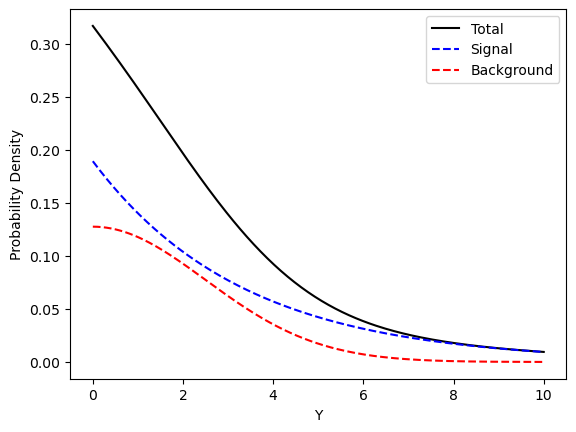

In [120]:
plt.plot(y, P_Y(y), 'k-', label='Total')
plt.plot(y, f*h_s(y), 'b--', label='Signal')
plt.plot(y, (1-f)*h_b(y), 'r--', label='Background')
plt.xlabel('Y')
plt.ylabel('Probability Density')
plt.legend()

Plot joint pdf $F(X,Y) = f g_s(X)h_s(Y) + (1-f) g_b(X)h_s(Y)$

Text(0.5, 1.0, 'Joint PDF')

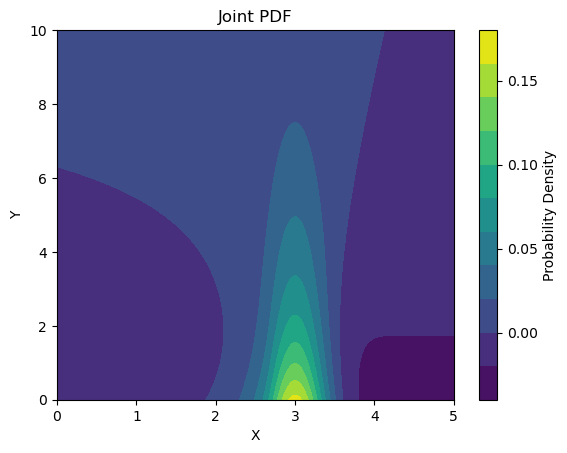

In [121]:
X, Y = np.meshgrid(x,y)

def signal_joint (X, Y):
    return f * g_s(X) * h_s (Y)

def background_joint (X, Y):
    return (f-1) * g_b (X) * h_b(Y)

def joint_pdf (X, Y):
    return signal_joint (X, Y) + background_joint(X, Y)

contour = plt.contourf(X, Y, joint_pdf(X, Y), levels = 10, cmap = 'viridis')
cbar = plt.colorbar(contour)
cbar.set_label("Probability Density")
cbar.set_ticks([0, 0.05, 0.1, 0.15])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Joint PDF')

In [122]:
#write numba-stats functions
@njit(float64(float64, float64))
def signal_joint_nb(X, Y):
   return f * g_s_nb(X, beta, m, mu, sigma, X_llim, X_ulim) * h_s_nb(Y, lmbda, Y_llim, Y_ulim)

@njit(float64(float64, float64))
def background_joint_nb(X, Y):
   return (1-f) * g_b_nb(X, X_llim, X_ulim) * h_b_nb(Y, mu_b, sigma_b, Y_llim, Y_ulim)

@njit(float64(float64, float64))
def joint_pdf_nb(X, Y):
   return signal_joint_nb(X, Y) + background_joint_nb(X, Y)

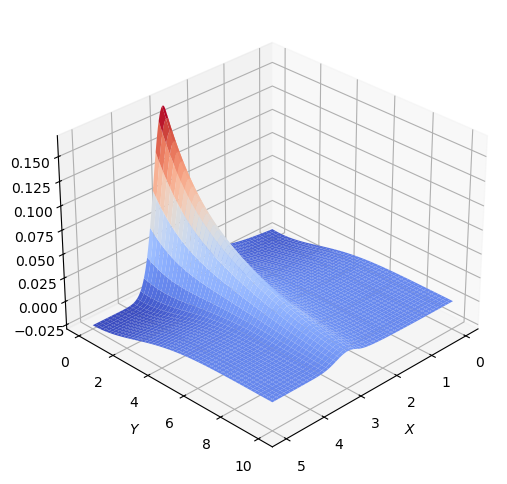

In [123]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
_ = ax.plot_surface(X, Y, joint_pdf(X, Y), cmap='coolwarm' )
ax.view_init(elev=30, azim=45)

Make an accept-reject simulator for 2d to sample from the joint distribution

In [124]:
#modify the above function to be able to handle 2d
def find_fmax_2d(func, x_range = (X_llim, X_ulim), y_range = (Y_llim, Y_ulim)):
    f_to_min = lambda vars: -func(vars[0], vars[1])
    initial_guess = [0,1]
    result = minimize(f_to_min, x0 = initial_guess, bounds = [x_range, y_range])
    max_x, max_y = result.x
    max_f = func(max_x, max_y)
    return max_f

find_fmax_2d (joint_pdf)

0.1669793986946343

In [129]:
def accept_reject_2d(func, x_range = (X_llim, X_ulim), y_range = (Y_llim, Y_ulim), num_samples = 50, seed = 42):
    np.random.seed(seed)
    fmax = find_fmax_2d (func, x_range, y_range)
    count = 0
    while count < num_samples:
        x_temp = np.random.uniform(x_range[0], x_range[1])
        y_temp = np.random.uniform(y_range[0], y_range[1])
        f_temp = np.random.uniform(0, fmax)
        if f_temp < func(x_temp, y_temp):
            count += 1
            yield x_temp, y_temp

@njit
def accept_reject_2d_nb(func, x_range = (X_llim, X_ulim), y_range = (Y_llim, Y_ulim), num_samples = 50, seed = 42):
    np.random.seed(seed)
    fmax = find_fmax_2d(func, x_range, y_range)
    x_samples = np.zeros(num_samples)
    y_samples = np.zeros(num_samples)
    count = 0
    while count < num_samples:
        x_temp = np.random.uniform(x_range[0], x_range[1])
        y_temp = np.random.uniform(y_range[0], y_range[1])
        f_temp = np.random.uniform(0, fmax)
        if f_temp < func(x_temp, y_temp):
            x_samples[count] = x_temp
            y_samples[count] = y_temp
            count += 1
    return x_samples, y_samples

In [126]:
joint_pdf_sample = np.array(list(accept_reject_2d(joint_pdf, num_samples = 100000))) #takes approx 10s for 1k samples
#np.savetxt('data_storage/joint_pdf_sample.csv', joint_pdf_sample, delimiter=',', header = 'X,Y', comments = '')

KeyboardInterrupt: 

In [156]:
joint_pdf_sample = np.loadtxt('data_storage/joint_pdf_sample.csv', delimiter=",", skiprows = 1)

In [157]:
joint_pdf_sample

array([[2.99329242, 1.5601864 ],
       [2.57117219, 5.92414569],
       [3.03772426, 1.70524124],
       ...,
       [2.97236739, 6.32220328],
       [3.14947413, 4.57215142],
       [3.09431133, 0.90616498]])

In [131]:
joint_pdf_sample = np.array(accept_reject_2d(joint_pdf_nb, num_samples = 100000))